#### <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea">Plant Seedlings Classification
##### <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea">Project 8

### by Anthony Amabile
The agriculture industry is very labor intensive with a lot of work being done manually to check if plants are growing and identifying and removing weeds. This trillion-dollar industry is ripe for transformation as artificial intelligence can aid in the identification and classificaion of various plants, thus freeing up a magnitude of capacity for human works.

This project aims to create a Convolutional Neural Network (CNN) to classify the plant seedlings into 12 categories.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Reading the training images from the path and labelling them into the given categories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # this is an important module to get imported which may even cause issues while reading the data if not used
import seaborn as sns # for data visualization 
import tensorflow as tf
import keras
import os
import sklearn

from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend 
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam,SGD #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator   
from google.colab.patches import cv2_imshow

Reading the Training Data

In [4]:
labels = pd.read_csv('/content/drive/MyDrive/Texas AI ML/Intro to Computer Vision/Labels.csv')

In [5]:
images = np.load('/content/drive/MyDrive/Texas AI ML/Intro to Computer Vision//images.npy')

In [6]:
print(f'The shape of the labels dataset is {labels.shape} and the shape of the images dataset is {images.shape}.')

The shape of the labels dataset is (4750, 1) and the shape of the images dataset is (4750, 128, 128, 3).


There are 4,750 RGB  images of shape 128 x 128 X 3, each image having 3 channels.

In [7]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

Text(0.5, 1.0, 'Distribution of classes')

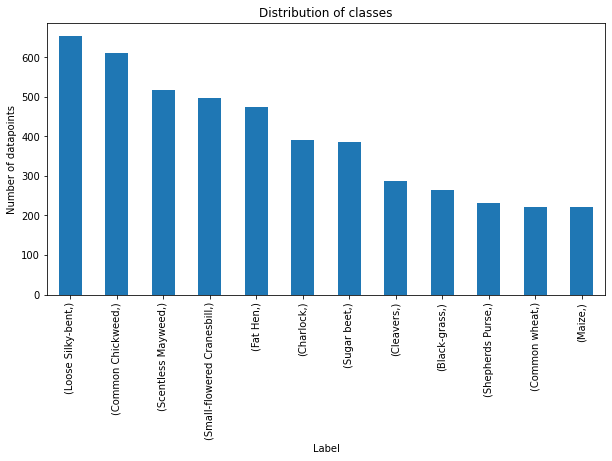

In [8]:
plt.figure(figsize=(10,5))
graph = labels.value_counts().plot(kind='bar')
plt.ylabel('Number of datapoints')
plt.title('Distribution of classes')

In [9]:
def plot_images(images,labels):
  num_classes=12                                                                  
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      
  rows = 3                                                                        
  cols = 4                                                                        
  fig = plt.figure(figsize=(10, 8))                                               
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      
          ax.imshow(images[random_index, :])                                       
          ax.set_title(keys[random_index])
  plt.show()

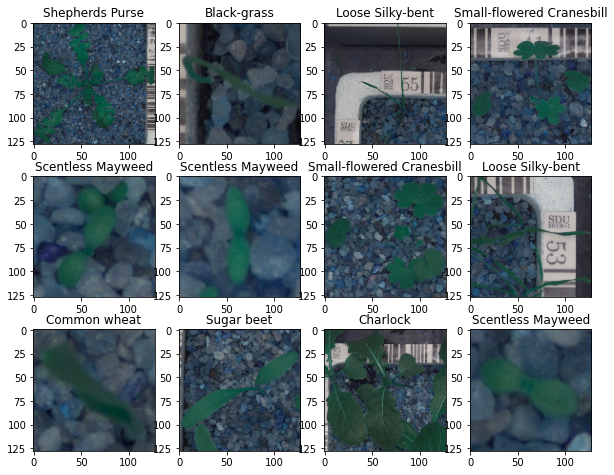

In [10]:
plot_images(images,labels)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

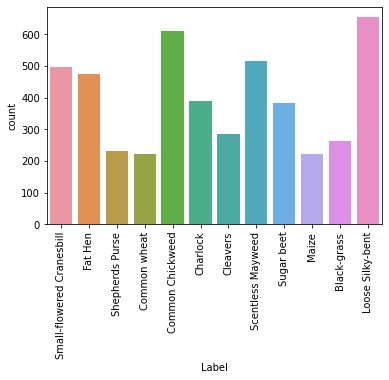

In [11]:
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical')

In [12]:
pd.options.display.float_format = '{:,.2f}'.format
labels.value_counts(normalize=True)*100

Label                    
Loose Silky-bent            13.77
Common Chickweed            12.86
Scentless Mayweed           10.86
Small-flowered Cranesbill   10.44
Fat Hen                     10.00
Charlock                     8.21
Sugar beet                   8.11
Cleavers                     6.04
Black-grass                  5.54
Shepherds Purse              4.86
Common wheat                 4.65
Maize                        4.65
dtype: float64

- As you can see from the above plot, the dataset is fairly balanced with no one category being more than 15% of the total images.
- There are between 200 and 700 images in each category.

In [13]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

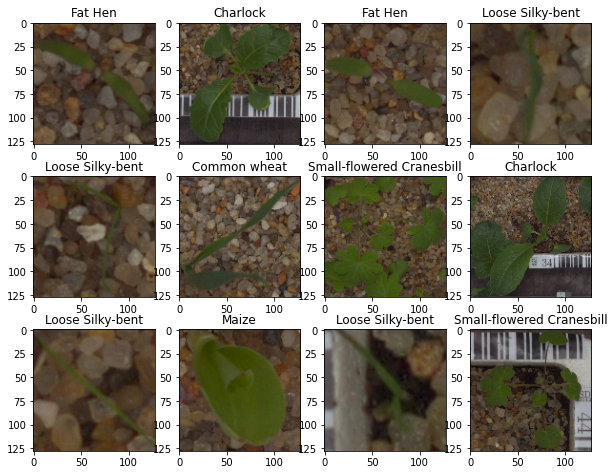

In [14]:
plot_images(images,labels)

The images look better after converting to RGB.

### Resizing images 
The image sizes will be reduced from 128 to 64 to make it computationally easier to process. 

In [15]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

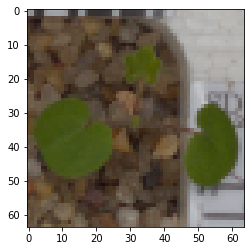

In [16]:
plt.imshow(images_decreased[2])

### Visualizing images using Gaussian Blur 

Unwanted noise will be removed from the images using Gaussian Blurring

In [17]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))


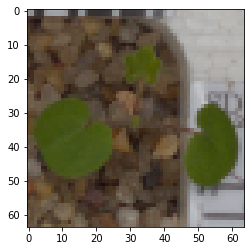

In [18]:
plt.imshow(images_decreased[2])

The image appears to be sharper after applyig Gaussian Blurring. This should help train our model by helping to identify the features of the various plant seedlings.

Splitting the Data


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)

In [20]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4275, 64, 64, 3) (4275, 1)
(475, 64, 64, 3) (475, 1)


In [21]:
X_train.shape[0]

4275

Normalizing the Data

In [22]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

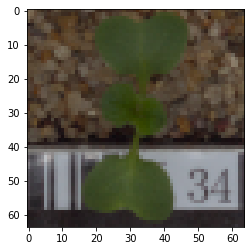

In [23]:
plt.imshow(X_train_normalized[2])

Encoding the Target Variable

In [24]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_test_encoded=enc.transform(y_test)

## Model Building - Convolutional Neural Network (CNN)

In [25]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()  

In [26]:
import random
np.random.seed(1) #for numpy
random.seed(1) 
tf.random.set_seed(1) #for tensorflow

In [27]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

In [28]:
model_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_split=0.1,
            # shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 12s - loss: 2.4540 - accuracy: 0.1243 - val_loss: 2.3951 - val_accuracy: 0.1262 - 12s/epoch - 97ms/step
Epoch 2/30
121/121 - 2s - loss: 2.2315 - accuracy: 0.2558 - val_loss: 2.0422 - val_accuracy: 0.3341 - 2s/epoch - 14ms/step
Epoch 3/30
121/121 - 2s - loss: 2.0018 - accuracy: 0.3018 - val_loss: 1.7898 - val_accuracy: 0.3832 - 2s/epoch - 14ms/step
Epoch 4/30
121/121 - 2s - loss: 1.8954 - accuracy: 0.3288 - val_loss: 1.7044 - val_accuracy: 0.4299 - 2s/epoch - 13ms/step
Epoch 5/30
121/121 - 2s - loss: 1.8287 - accuracy: 0.3473 - val_loss: 1.6119 - val_accuracy: 0.4836 - 2s/epoch - 13ms/step
Epoch 6/30
121/121 - 2s - loss: 1.7615 - accuracy: 0.3676 - val_loss: 1.6354 - val_accuracy: 0.4883 - 2s/epoch - 13ms/step
Epoch 7/30
121/121 - 2s - loss: 1.7489 - accuracy: 0.3709 - val_loss: 1.5470 - val_accuracy: 0.5210 - 2s/epoch - 13ms/step
Epoch 8/30
121/121 - 2s - loss: 1.7118 - accuracy: 0.3712 - val_loss: 1.4781 - val_accuracy: 0.5187 - 2s/epoch - 13ms/step
Epoch 9/30
121

### **Model Evaluation**

This model is only accurate a litle more than half the time and needs to be improved. It is not overfit as the accuracy is improved on the validation set compared to the training data. 

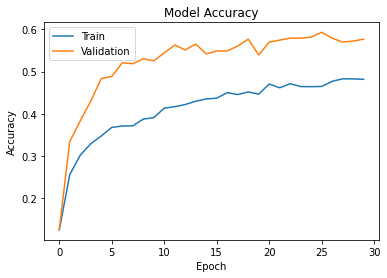

In [29]:
plt.plot(model_1.history['accuracy'])
plt.plot(model_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

While the model may be close to plateauing in improving performance with each epoch at the 25th epoch and beyond, it may also have more to learn to aid in the classification before it learns too much noise. 
Both training and validation accuracy generally improved with each epoch.

More epochs will be added in another model to see if that improves accruacy.

In [30]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.1960 - accuracy: 0.5916 - 177ms/epoch - 12ms/step


### **Predictions using test data**

In [31]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

In [32]:
y_pred

array([[5.59458458e-13, 3.46716442e-05, 2.23938628e-08, ...,
        1.03552975e-02, 5.75514264e-07, 4.34981921e-04],
       [5.05448134e-18, 2.62883696e-04, 2.62932823e-04, ...,
        1.10446510e-03, 9.69299197e-01, 8.65884684e-03],
       [1.51276691e-12, 1.53751989e-05, 2.10321974e-04, ...,
        2.00349852e-04, 8.82273316e-01, 3.27034742e-02],
       ...,
       [2.46562719e-01, 9.35450295e-09, 2.13065978e-05, ...,
        5.45150840e-07, 8.15077146e-06, 2.09844511e-05],
       [1.34332950e-05, 1.98948421e-02, 1.23735918e-02, ...,
        3.90136801e-02, 6.65275875e-05, 5.93434200e-02],
       [1.85812043e-11, 1.85804173e-01, 4.65784315e-03, ...,
        3.35633159e-01, 3.13181221e-01, 3.71230058e-02]], dtype=float32)

### **Confusion Matrix**

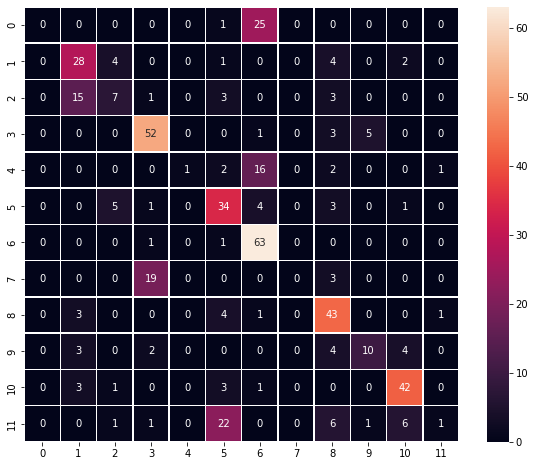

In [33]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

### Observations  <br>
- Some of the classes are not predicted correctly. In particular, class zero is not predicted correctly at all.
- You can see that several classes (0, 4, and 5) are being incorrectly classified as class 6.
- In comparison to the rest, we can see that classes 6,3, and 10 are relatively well classified.
- We can also observe that classes 0, 4 and 7 are mostly misclassified and in fact aren't identified at all in the model.

### Model 2

For this second model, epochs and layers will be increased to see if performance imrpoves.

In [34]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()  

In [35]:
import random
np.random.seed(1) #for numpy
random.seed(1) 
tf.random.set_seed(1) #for tensorflow

In [36]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Additional layer for model 2
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Additional layer for model 2
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

In [37]:
model_2 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=40,
            validation_split=0.1,
            # shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/40
121/121 - 3s - loss: 2.4185 - accuracy: 0.1515 - val_loss: 2.2746 - val_accuracy: 0.2336 - 3s/epoch - 25ms/step
Epoch 2/40
121/121 - 2s - loss: 2.1464 - accuracy: 0.2469 - val_loss: 1.9301 - val_accuracy: 0.3505 - 2s/epoch - 15ms/step
Epoch 3/40
121/121 - 2s - loss: 1.8999 - accuracy: 0.3093 - val_loss: 1.6981 - val_accuracy: 0.4136 - 2s/epoch - 14ms/step
Epoch 4/40
121/121 - 2s - loss: 1.7427 - accuracy: 0.3774 - val_loss: 1.5272 - val_accuracy: 0.4836 - 2s/epoch - 14ms/step
Epoch 5/40
121/121 - 2s - loss: 1.6382 - accuracy: 0.4099 - val_loss: 1.4445 - val_accuracy: 0.5187 - 2s/epoch - 14ms/step
Epoch 6/40
121/121 - 2s - loss: 1.5611 - accuracy: 0.4424 - val_loss: 1.3494 - val_accuracy: 0.5841 - 2s/epoch - 14ms/step
Epoch 7/40
121/121 - 2s - loss: 1.4832 - accuracy: 0.4650 - val_loss: 1.2881 - val_accuracy: 0.5654 - 2s/epoch - 14ms/step
Epoch 8/40
121/121 - 2s - loss: 1.4681 - accuracy: 0.4713 - val_loss: 1.2412 - val_accuracy: 0.6121 - 2s/epoch - 14ms/step
Epoch 9/40
121/1

### **Model Evaluation**

Performance has improved with more epochs and extra layers. Accuracy has been improved to 74% in the validation set.

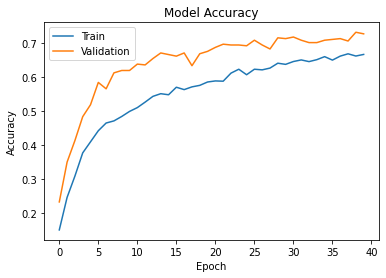

In [38]:
plt.plot(model_2.history['accuracy'])
plt.plot(model_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Both training and validation accuracy continued to improved with each epoch.

In [39]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.9282 - accuracy: 0.7179 - 149ms/epoch - 10ms/step


### **Predictions using test data**

In [40]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

In [41]:
y_pred

array([[1.88502832e-22, 1.29917552e-25, 2.86376938e-18, ...,
        1.70820094e-05, 1.89911143e-13, 7.54512655e-07],
       [1.37811202e-16, 1.82333708e-01, 2.10111393e-04, ...,
        6.54680207e-02, 7.50013173e-01, 4.63333679e-04],
       [3.86510338e-11, 3.02020862e-06, 6.15968574e-08, ...,
        8.83716717e-03, 9.58738685e-01, 1.83240511e-02],
       ...,
       [2.41812229e-01, 3.25844528e-14, 6.61244849e-04, ...,
        4.61035375e-16, 1.83930261e-15, 2.02540705e-05],
       [2.10102996e-07, 3.09090428e-05, 6.54421281e-04, ...,
        1.06942475e-01, 2.05561037e-06, 1.67233180e-02],
       [7.47767093e-09, 1.31766533e-03, 7.93064071e-04, ...,
        5.67839384e-01, 3.25065441e-02, 1.21420257e-01]], dtype=float32)

### **Confusion Matrix**

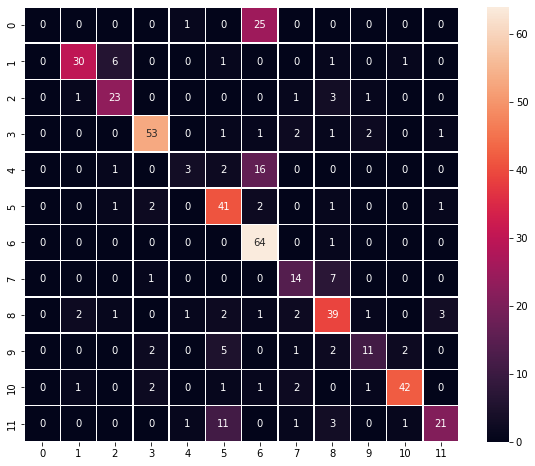

In [42]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

### Observations  <br>
- Some of the classes are still not predicted correctly, however, the predictions have improved.
- You can see that several classes (0 and 4) are still being incorrectly classified as class 6.
- We can see that classes 6,3, and 10 are still being relatively well-classified, especially in comparision with the other classes.
- We can also observe that classes 0, 4 and 7 are still the least well classified, but aside from class 0, classes 4 and 7 are being identfied in this model when they were not in our initial model.

### Model 3

Model 2 will be further built on by augmentating the data in  an attempt to improve performance.

In [43]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [44]:
# All images to be rescaled by 1/255, rotated by 30 degrees, flipped horizontally and vertically, 
# widths and heights shifted slightly, and zoomed slightly.
train_datagen = ImageDataGenerator(
                              rotation_range=30,  horizontal_flip=True, vertical_flip=True, width_shift_range=0.03,
        shear_range=0.1, height_shift_range=0.1, zoom_range=0.08, rescale = 1.0/255, fill_mode='nearest'
                              )


In [45]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Additional layer for model 2
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Additional layer for model 2
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

In [46]:
# Epochs
epochs = 40
# Batch size
batch_size = 32

model_3 = model.fit(train_datagen.flow(
            X_train_normalized, y_train_encoded,
            batch_size=batch_size, 
                                       seed=1,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_test_normalized,y_test_encoded),
                    verbose=1)

Epoch 1/40
133/133 [==============================] - 9s 62ms/step - loss: 2.4509 - accuracy: 0.1372 - val_loss: 3.1158 - val_accuracy: 0.1284
Epoch 2/40
133/133 [==============================] - 8s 58ms/step - loss: 2.4425 - accuracy: 0.1334 - val_loss: 2.4636 - val_accuracy: 0.1368
Epoch 3/40
133/133 [==============================] - 9s 71ms/step - loss: 2.4279 - accuracy: 0.1362 - val_loss: 2.4596 - val_accuracy: 0.1368
Epoch 4/40
133/133 [==============================] - 8s 59ms/step - loss: 2.4247 - accuracy: 0.1242 - val_loss: 2.4223 - val_accuracy: 0.1368
Epoch 5/40
133/133 [==============================] - 8s 58ms/step - loss: 2.4285 - accuracy: 0.1273 - val_loss: 2.4172 - val_accuracy: 0.1368
Epoch 6/40
133/133 [==============================] - 8s 59ms/step - loss: 2.4233 - accuracy: 0.1322 - val_loss: 2.4157 - val_accuracy: 0.1368
Epoch 7/40
133/133 [==============================] - 8s 60ms/step - loss: 2.4202 - accuracy: 0.1310 - val_loss: 2.4165 - val_accuracy: 0.1368

In this model it appears that the data was augmented too much. We will try again with data augmentation but with only one or two augmentation techniques.

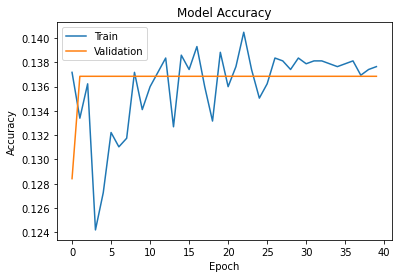

In [47]:
plt.plot(model_3.history['accuracy'])
plt.plot(model_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

This model was awful. The data was augmented to be unrecognizable.

In [48]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 2.4149 - accuracy: 0.1368 - 156ms/epoch - 10ms/step


### **Predictions using test data**

In [49]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

### **Confusion Matrix**

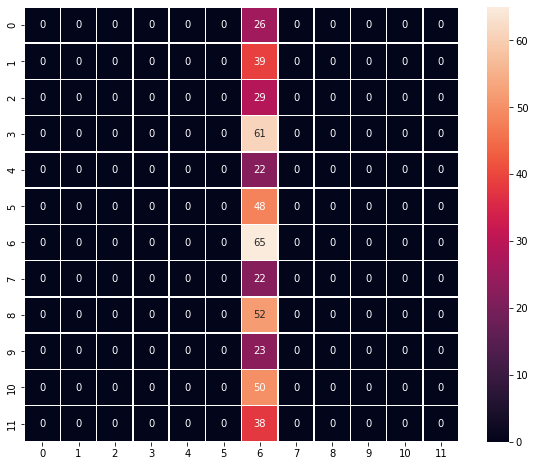

In [50]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

### Observations  <br>
- This model is useless as it identifies all classes as 6.

### Model 4

In [51]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [52]:
# All images to be rescaled by 1/255, rotated by 25 degrees

train_datagen = ImageDataGenerator(
                              rotation_range=25,  rescale = 1.0/255, fill_mode='nearest'
                              )


In [53]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Additional layer for model 2
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Additional layer for model 2
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

In [54]:
# Epochs
epochs = 40
# Batch size
batch_size = 32

model_4 = model.fit(train_datagen.flow(
            X_train_normalized, y_train_encoded,
            batch_size=batch_size, 
                                       seed=1,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_test_normalized,y_test_encoded),
                    verbose=1)

Epoch 1/40
133/133 [==============================] - 8s 55ms/step - loss: 2.4505 - accuracy: 0.1282 - val_loss: 3.7011 - val_accuracy: 0.1305
Epoch 2/40
133/133 [==============================] - 7s 54ms/step - loss: 2.4434 - accuracy: 0.1249 - val_loss: 2.5043 - val_accuracy: 0.1347
Epoch 3/40
133/133 [==============================] - 7s 54ms/step - loss: 2.4283 - accuracy: 0.1332 - val_loss: 2.4724 - val_accuracy: 0.1368
Epoch 4/40
133/133 [==============================] - 7s 55ms/step - loss: 2.4247 - accuracy: 0.1334 - val_loss: 2.4197 - val_accuracy: 0.1368
Epoch 5/40
133/133 [==============================] - 7s 55ms/step - loss: 2.4290 - accuracy: 0.1292 - val_loss: 2.4160 - val_accuracy: 0.1368
Epoch 6/40
133/133 [==============================] - 7s 55ms/step - loss: 2.4239 - accuracy: 0.1334 - val_loss: 2.4160 - val_accuracy: 0.1368
Epoch 7/40
133/133 [==============================] - 7s 54ms/step - loss: 2.4205 - accuracy: 0.1350 - val_loss: 2.4157 - val_accuracy: 0.1368

This model is just as bad as model 3 and not accurate at all.

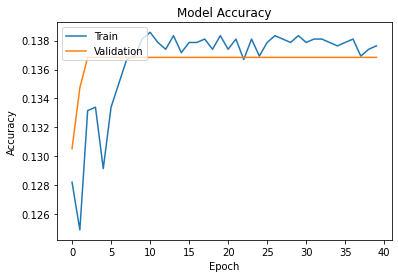

In [55]:
plt.plot(model_4.history['accuracy'])
plt.plot(model_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

This model appears to be slightly better than the last with just a couple of data augmentation techniques, but is still very unusable.

In [56]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 2.4150 - accuracy: 0.1368 - 152ms/epoch - 10ms/step


### **Generating the predictions using test data**

In [57]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

### Confusion Matrix ###

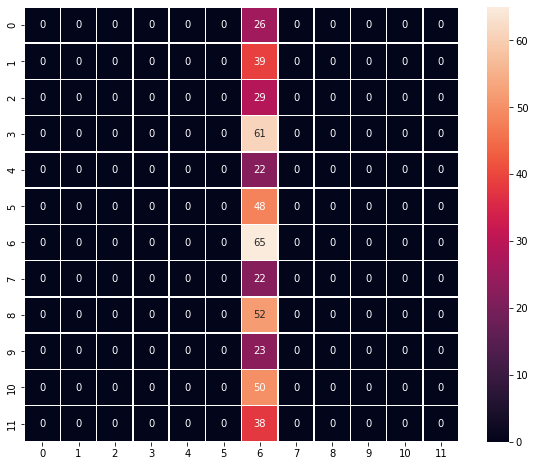

In [58]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

### Observations  <br>
- Like the previous model, this model is useless as it identifies all classes as 6.

### Model 5

The best performing model so far is model 2. This model will attempted to be further tuned by increasing the dropout rate.

In [59]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()  

In [60]:
import random
np.random.seed(1) #for numpy
random.seed(1) 
tf.random.set_seed(1) #for tensorflow

In [61]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Additional layer for model 2
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Additional layer for model 2
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())


# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))

#reducing the dropout rate from .3 to .35
model.add(Dropout(0.35))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

In [62]:
model_5 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=40,
            validation_split=0.1,
            # shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/40
121/121 - 3s - loss: 2.4493 - accuracy: 0.1339 - val_loss: 2.4340 - val_accuracy: 0.1238 - 3s/epoch - 24ms/step
Epoch 2/40
121/121 - 2s - loss: 2.2357 - accuracy: 0.2199 - val_loss: 1.9084 - val_accuracy: 0.3528 - 2s/epoch - 14ms/step
Epoch 3/40
121/121 - 2s - loss: 1.9419 - accuracy: 0.3145 - val_loss: 1.6598 - val_accuracy: 0.4206 - 2s/epoch - 14ms/step
Epoch 4/40
121/121 - 2s - loss: 1.7855 - accuracy: 0.3655 - val_loss: 1.5968 - val_accuracy: 0.4650 - 2s/epoch - 14ms/step
Epoch 5/40
121/121 - 2s - loss: 1.6738 - accuracy: 0.3933 - val_loss: 1.4292 - val_accuracy: 0.5257 - 2s/epoch - 14ms/step
Epoch 6/40
121/121 - 2s - loss: 1.6117 - accuracy: 0.4234 - val_loss: 1.4274 - val_accuracy: 0.5421 - 2s/epoch - 14ms/step
Epoch 7/40
121/121 - 2s - loss: 1.5222 - accuracy: 0.4500 - val_loss: 1.3101 - val_accuracy: 0.5374 - 2s/epoch - 14ms/step
Epoch 8/40
121/121 - 2s - loss: 1.5100 - accuracy: 0.4513 - val_loss: 1.2955 - val_accuracy: 0.5771 - 2s/epoch - 15ms/step
Epoch 9/40
121/1

Using Model # 2 and increasing the dropout rate slightly, improved performance slightly.

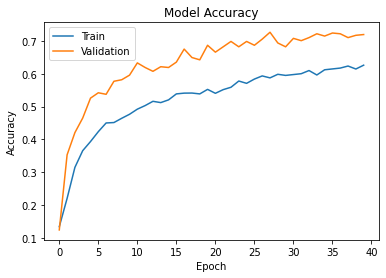

In [63]:
plt.plot(model_5.history['accuracy'])
plt.plot(model_5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Graphically, you can see how much better this model performs compared to earlier models.

In [64]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.8988 - accuracy: 0.7011 - 203ms/epoch - 14ms/step


### **Generating the predictions using test data**

In [65]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

### Confusion Matrix ###

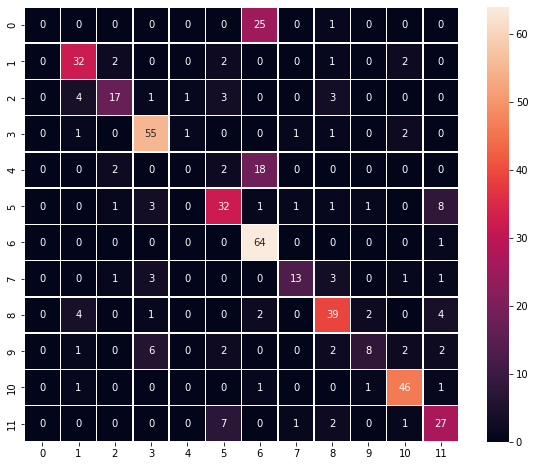

In [66]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

### Observations  <br>
- Along with model 2, this is one of the best performing models.

### Model 6

The best performing model so far is model 2. This model will attempted to be further tuned by increasing the dropout rate.

In [67]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()  

In [68]:
import random
np.random.seed(1) #for numpy
random.seed(1) 
tf.random.set_seed(1) #for tensorflow

In [69]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Additional layer for model 2
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Additional layer for model 2
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())


# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))

#reducing the dropout rate from .35 to .5
model.add(Dropout(0.5))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

In [70]:
model_6 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=40,
            validation_split=0.1,
            # shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/40
121/121 - 6s - loss: 2.4452 - accuracy: 0.1391 - val_loss: 2.3412 - val_accuracy: 0.2547 - 6s/epoch - 49ms/step
Epoch 2/40
121/121 - 2s - loss: 2.2278 - accuracy: 0.2290 - val_loss: 1.9221 - val_accuracy: 0.3668 - 2s/epoch - 20ms/step
Epoch 3/40
121/121 - 2s - loss: 1.9683 - accuracy: 0.3080 - val_loss: 1.6204 - val_accuracy: 0.4696 - 2s/epoch - 19ms/step
Epoch 4/40
121/121 - 3s - loss: 1.8032 - accuracy: 0.3564 - val_loss: 1.4922 - val_accuracy: 0.5047 - 3s/epoch - 21ms/step
Epoch 5/40
121/121 - 2s - loss: 1.7011 - accuracy: 0.3936 - val_loss: 1.3948 - val_accuracy: 0.5584 - 2s/epoch - 20ms/step
Epoch 6/40
121/121 - 2s - loss: 1.6181 - accuracy: 0.4125 - val_loss: 1.3531 - val_accuracy: 0.5561 - 2s/epoch - 20ms/step
Epoch 7/40
121/121 - 2s - loss: 1.5803 - accuracy: 0.4284 - val_loss: 1.4021 - val_accuracy: 0.5421 - 2s/epoch - 19ms/step
Epoch 8/40
121/121 - 3s - loss: 1.5555 - accuracy: 0.4310 - val_loss: 1.3754 - val_accuracy: 0.5514 - 3s/epoch - 21ms/step
Epoch 9/40
121/1

Increasing the dropout rate even more, improved performance slightly. This is the best performing model.

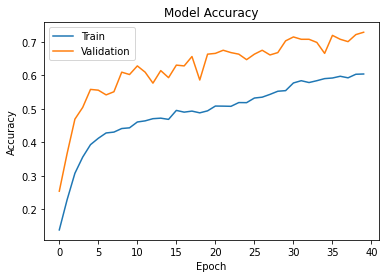

In [71]:
plt.plot(model_6.history['accuracy'])
plt.plot(model_6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Graphically, you can see how much better this model performs compared to earlier models. It's performance on the validation set is similar to models 2 and 5.

In [72]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.9522 - accuracy: 0.7242 - 146ms/epoch - 10ms/step


### **Generating the predictions using test data**

In [73]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

### Confusion Matrix ###

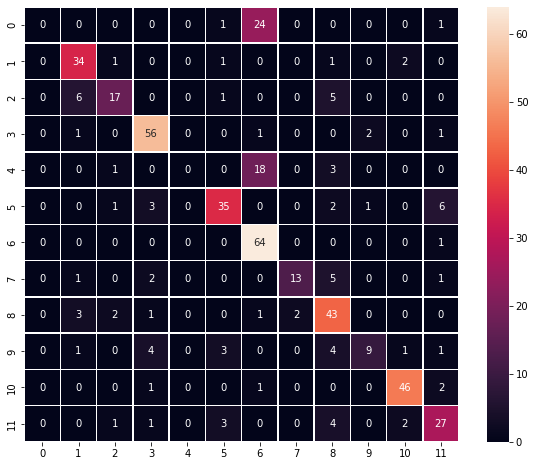

In [74]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

### Observations  <br>
- Along with model 2 and 5 this is one of the best performing models.

## **Visualizing the prediction:**

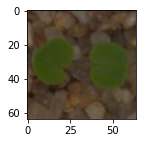

Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


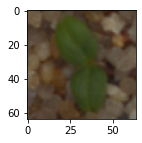

Predicted Label ['Cleavers']
True Label Cleavers


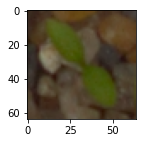

Predicted Label ['Common Chickweed']
True Label Common Chickweed


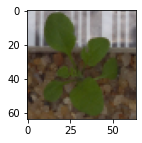

Predicted Label ['Charlock']
True Label Shepherds Purse


In [75]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

In [77]:
print('Best Performing Models:')
pd.DataFrame({'Models':['Model 2','Model 5','Model 6'],'Train Accuracy':['67%','60%','60%'],'Test Accuracy':['72%','70%','72%']})

Best Performing Models:


,Models,Train Accuracy,Test Accuracy
0,Model 2,67%,72%
1,Model 5,60%,70%
2,Model 6,60%,72%


## Conclusion
- We can observe from the confusion matrix of all the models that model #2 was the best model because it predicted the majority of the classes better than the other models at 72%. Model #2 also had a higher training accuracy at 67% compared to model #6 which seemingly has the same accuracy as model #2.

- However, I believe there was a data leak somewhere in the process because upon first running models #5 and #6, the accuracy was higher than that of model #2.

- Data Augmentation was not helpful in improving the model.

- When using the model in practice, it identifies the correct seedling roughly 3 out f 4 times. This model can be used in production as an initial model to help agricultural workers reduce the number of seedlings to manually review. Agricultural workers can focus their efforts on correctly identifying and reviewing the seedlings that the model classified as class 0, 4, 6, and 9 because those are the classes with which our model has a hard time correctly classifying.